Image Rotation
========

A consideration of Unser et al.

As written, this is completely buggy for interpolation orders higher than linear.  This is due to the following behavior of scipy interpolate

For orders higher than 1, scipy interpolate will propagate nans throughout the entire dataset
scipy interpolate fits a spline to the whole dataset - the result seems extremely unstable for even ordered splines.

See https://github.com/scipy/scipy/issues/4060
and https://github.com/scipy/scipy/issues/6988


In [70]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rotate as ski_rotate
from skimage.transform import rescale as ski_scale
from scipy.interpolate import interp1d

%matplotlib inline
def show(img):
    im=plt.imshow(img,cmap='gray')
    plt.gca().axis('off')

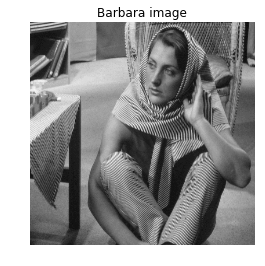

(128, 128)


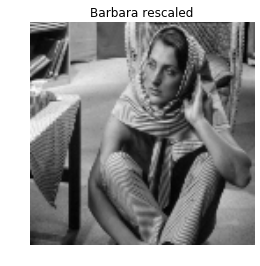

In [64]:
barbara=skio.imread("Data/barbara.bmp").astype(np.float)
show(barbara)
dummy=plt.title("Barbara image")
plt.show()
bsmall=ski_scale(barbara,(0.25,0.25))
print bsmall.shape
show(bsmall)
dummy=plt.title("Barbara rescaled")
plt.show()


In [14]:
def rotate_fullcircle(img,steps,rotation_algorithm):
    out=img.copy()
    angle=360./steps
    for i in range(steps):
        out=rotation_algorithm(out,angle)
    return out

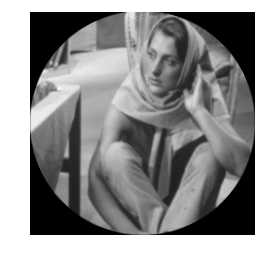

In [46]:
img=rotate_fullcircle(barbara,15,lambda x,a:ski_rotate(x,a,order=1))
show(img)

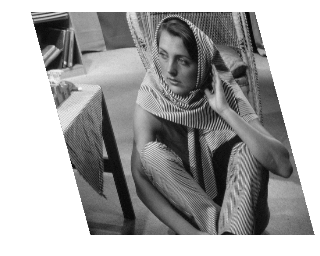

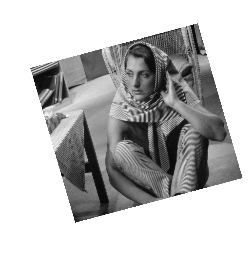

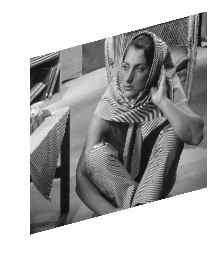

In [72]:
def clamp(x):
    return x
    if x<=0:
        return 0
    elif x>=255:
        return 255
    else:
        return x
#def nanfilter(x,y):
#    # strip off ends that contain nan and other numerical weirdness
#    y=y[:]
#    return x[np.isfinite(y)],y[np.isfinite(y)]
    
# allowable kinds
#‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic, ‘cubic’ or integer order
# but some are slow - very slow - and it looks like the kernel is frozen
    
def xshear(img,s,kind='linear'): 
    offset=int(np.ceil(s*img.shape[0]))
    # this tweaks the placement so the center always ends up in the actual center
    shift=(offset - s*np.float(img.shape[0]))/2.
    newsize=(img.shape[0],np.abs(offset)+img.shape[1])
    if offset<0:
        offset=abs(offset)
    else:
        offset=0
    out=np.zeros(newsize)
    for row in range(img.shape[0]):
       #xin,yin=nanfilter(np.asarray(range(img.shape[1])),img[row,:])
       f=interp1d(np.asarray(range(img.shape[1])),img[row,:],kind=kind,bounds_error=False,assume_sorted=True)
       pts=np.asarray(range(newsize[1]))-shift-offset-s*np.float(row)
       out[row,:]=map(clamp,f(pts))
    return out

def yshear(img,s,kind='linear',ctr=(0,0)):
    #inefficient, but avoids code duplication
    tmp1=np.rot90(img,k=1)
    tmp2=xshear(tmp1,s,kind)
    return np.rot90(tmp2,k=-1)
    
    
z=xshear(barbara,np.tan(np.deg2rad(15)),'cubic')
show(z)
plt.show()
z=yshear(z,np.tan(np.deg2rad(15)))
show(z)
plt.show()
z=yshear(barbara,np.tan(np.deg2rad(15)))
show(z)
plt.show()

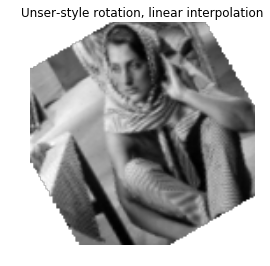

In [73]:
def unser_rotate(img,angle,kind):
    xs=np.tan(np.deg2rad(angle)/2.)
    ys=np.sin(np.deg2rad(angle))
    tmp1=xshear(img,xs,kind)
    tmp2=yshear(tmp1,ys,kind)
    tmp3=xshear(tmp2,xs,kind)
    a,b=tmp3.shape
    c,d=img.shape
    return tmp3[(a-c)//2:(a-c)//2+c,(b-d)//2:(b-d)//2+d] 

z=unser_rotate(bsmall,30,'linear')
show(z)
dummy=plt.title("Unser-style rotation, linear interpolation")




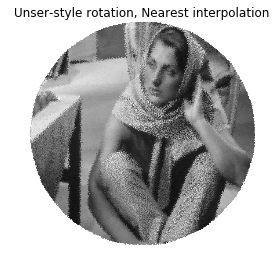

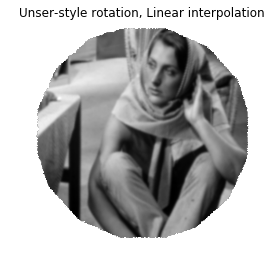

In [74]:
# Here are rotated images using different orders of interpolation
# When you run this block, be patient, it takes a loooooong time
img=rotate_fullcircle(barbara,15,lambda x,a:unser_rotate(x,a,'nearest'))
show(img)
dummy=plt.title("Unser-style rotation, Nearest interpolation")
plt.show()

img=rotate_fullcircle(barbara,15,lambda x,a:unser_rotate(x,a,'linear'))
show(img)
dummy=plt.title("Unser-style rotation, Linear interpolation")
plt.show()

#due to strange behavior in scipy interpolate, this is not goign to work
#img=rotate_fullcircle(barbara,15,lambda x,a:unser_rotate(x,a,'quadratic'))
#  show(img)
#dummy=plt.title("Unser-style rotation, Quadratic interpolation")
#plt.show()

#img=rotate_fullcircle(barbara,15,lambda x,a:unser_rotate(x,a,'cubic'))
#show(img)
#dummy=plt.title("Unser-style rotation, Cubic interpolation")
#plt.show()

#img=rotate_fullcircle(barbara,15,lambda x,a:unser_rotate(x,a,5))
#show(img)
#dummy=plt.title("Unser-style rotation, 5th order interpolation")
#plt.show()

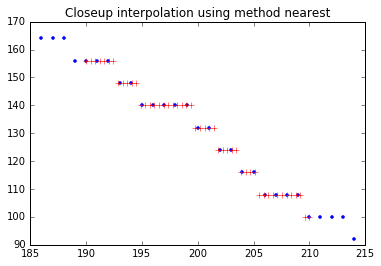

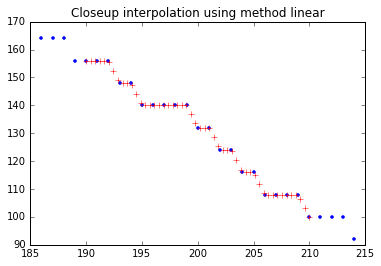

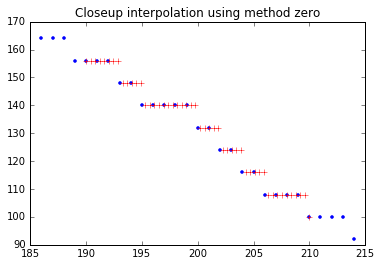

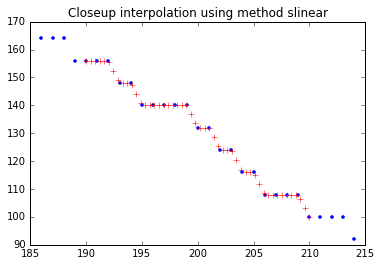

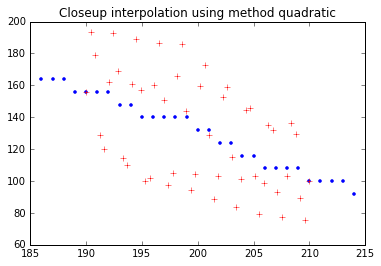

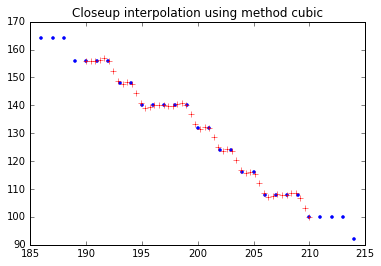

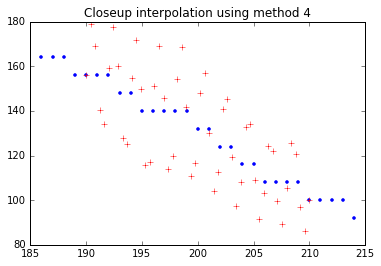

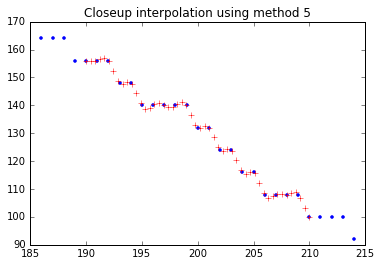

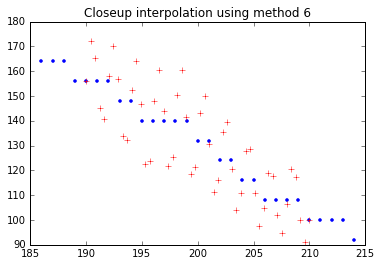

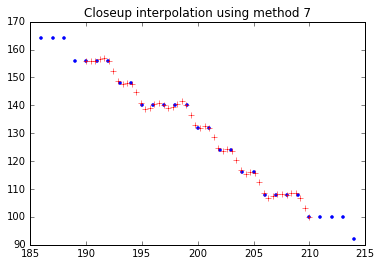

In [75]:
#shows some of the strange behavior, see also linked issue reports
for kind in ['nearest','linear','zero','slinear','quadratic','cubic',4,5,6,7]:
   x=np.linspace(0,511,512)
   #y=np.sin(x) #barbara[256,:]
   m=200
   y=barbara[256,:]
   f=interp1d(x,y,kind=kind,bounds_error=False,assume_sorted=True)
   x2=np.linspace(m-10,m+10,50) #-128,512+128-1,512+256)
   y2=f(x2)
   #y2[not np.isnan(y2) and y2>150]=150
   #y2[not np.isnan(y2) and y2<50]=50
   dummy=plt.plot(x[m-14:m+15],y[m-14:m+15],'b.',x2,y2,'r+')
   dummy=plt.title("Closeup interpolation using method %s"%(kind,))
   plt.show()